<a href="https://colab.research.google.com/github/mosh98/Swedish_Sentiment_BERTIL/blob/main/Swe_Bert_Training_Bigger_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Analyzer
Using the latest Bert model released by National library of Sweden

KB/BERT: https://github.com/Kungbib/swedish-bert-models


Dataset from : https://github.com/stoffesvensson/DeepLearning-ThesisWork-Convolutional


Make sure you use GPU
Click on Runtime->Change Runtime Type -> Select GPU -> SAVE

In [1]:
!nvidia-smi

Wed Dec  2 07:02:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Importing Relavant Packages and Files

In [2]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
#from transformers import BertModel
from collections import Counter

In [3]:
import pandas as pd
!git clone https://github.com/Kungbib/swedish-bert-models
!cd swedish-bert-models
!python3 -m venv venv
!source venv/bin/activate
!pip install --upgrade pip
!pip install -r /content/swedish-bert-models/requirements.txt

fatal: destination path 'swedish-bert-models' already exists and is not an empty directory.
The virtual environment was not created successfully because ensurepip is not
available.  On Debian/Ubuntu systems, you need to install the python3-venv
package using the following command.

    apt-get install python3-venv

You may need to use sudo with that command.  After installing the python3-venv
package, recreate your virtual environment.

Failing command: ['/content/venv/bin/python3', '-Im', 'ensurepip', '--upgrade', '--default-pip']

/bin/bash: venv/bin/activate: No such file or directory


In [4]:
!mkdir data
!mkdir temp
!wget https://github.com/ks222rt/DeepLearning-ThesisWork-Convolutional/raw/master/cnn-model/datasets/testDatasetWithNeuTwo -O temp/train.csv
!wget https://github.com/ks222rt/DeepLearning-ThesisWork-Convolutional/raw/master/cnn-model/datasets/testDatasetWithNeuOne -O temp/val.csv

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘temp’: File exists
--2020-12-02 07:02:46--  https://github.com/ks222rt/DeepLearning-ThesisWork-Convolutional/raw/master/cnn-model/datasets/testDatasetWithNeuTwo
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/stoffesvensson/DeepLearning-ThesisWork-Convolutional/raw/master/cnn-model/datasets/testDatasetWithNeuTwo [following]
--2020-12-02 07:02:46--  https://github.com/stoffesvensson/DeepLearning-ThesisWork-Convolutional/raw/master/cnn-model/datasets/testDatasetWithNeuTwo
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/stoffesvensson/DeepLearning-ThesisWork-Convolutional/master/cnn-model/datasets/testDatasetWithNeuTwo [following]
--2020-12-02 07:02:46--  

In [5]:
!wget https://raw.githubusercontent.com/stoffesvensson/DeepLearning-ThesisWork-Convolutional/master/cnn-model/datasets/datasetWithoutNeutral -O temp/full_data.csv

--2020-12-02 07:02:47--  https://raw.githubusercontent.com/stoffesvensson/DeepLearning-ThesisWork-Convolutional/master/cnn-model/datasets/datasetWithoutNeutral
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4305995 (4.1M) [text/plain]
Saving to: ‘temp/full_data.csv’

temp/full_data.csv  100%[===================>]   4.11M  --.-KB/s    in 0.04s   

2020-12-02 07:02:47 (97.6 MB/s) - ‘temp/full_data.csv’ saved [4305995/4305995]



#Basic Data cleaning
Most of the data was already cleaned and labeled thanks to [Kristoffer](https://https://github.com/stoffesvensson)


In [6]:
#dataset kommer ifrån  https://spraakbanken.gu.se/resurser/sentimentlex
df = pd.read_csv("/content/temp/full_data.csv",error_bad_lines=False)
df

,index,text,rating
0,1,kanonsnabb leverans,positive
1,2,appen funkar kanon! det enda som är lite skabb...,positive
2,3,"i tid, trevliga och utförde ett bra jobb. jag ...",positive
3,4,jag har betalat extra för en express leverans....,negative
4,5,fungerade fint med bokning och service och mat...,positive
...,...,...,...
14291,14292,beställde en bilbarnstol till mitt barnbarn so...,negative
14292,14293,varning för lång leveranstid trots att varan f...,negative
14293,14294,fick inte alla skruvar med när jag beställde e...,negative
14294,14295,ett av få företag som svarar i telefon omedelb...,positive


In [7]:

#convert polarity into numbers or binary
dataset__sentence_label = df[['text','rating']]
dataset__sentence_label.replace({'neutral': np.NaN},inplace=True)
dataset__sentence_label = dataset__sentence_label.dropna()
print(dataset__sentence_label)
sentence = dataset__sentence_label.text
label = dataset__sentence_label.rating

#sentence

                                                    text    rating
0                                   kanonsnabb leverans   positive
1      appen funkar kanon! det enda som är lite skabb...  positive
2      i tid, trevliga och utförde ett bra jobb. jag ...  positive
3      jag har betalat extra för en express leverans....  negative
4      fungerade fint med bokning och service och mat...  positive
...                                                  ...       ...
14291  beställde en bilbarnstol till mitt barnbarn so...  negative
14292  varning för lång leveranstid trots att varan f...  negative
14293  fick inte alla skruvar med när jag beställde e...  negative
14294  ett av få företag som svarar i telefon omedelb...  positive
14295  behöver inte hålla på att springa till p-autom...  positive

[14296 rows x 2 columns]


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [8]:
print(Counter(label))

Counter({'positive': 9667, 'negative': 4629})


In [9]:
frames = [sentence,label]
new_df = pd.concat(frames,axis=1)

#data["income"].replace({ ' <=50K': 0, ' >50K':1 }, inplace=True)
new_df["rating"].replace({'positive':1,'negative':0},inplace=True)
print(new_df)
new_df.info()
print("================================")
print()
print()
print()

print(Counter(new_df.rating))

                                                    text  rating
0                                   kanonsnabb leverans        1
1      appen funkar kanon! det enda som är lite skabb...       1
2      i tid, trevliga och utförde ett bra jobb. jag ...       1
3      jag har betalat extra för en express leverans....       0
4      fungerade fint med bokning och service och mat...       1
...                                                  ...     ...
14291  beställde en bilbarnstol till mitt barnbarn so...       0
14292  varning för lång leveranstid trots att varan f...       0
14293  fick inte alla skruvar med när jag beställde e...       0
14294  ett av få företag som svarar i telefon omedelb...       1
14295  behöver inte hålla på att springa till p-autom...       1

[14296 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14296 entries, 0 to 14295
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1

Holdout set for testing classifier


In [10]:
#negative=new_df[new_df['rating']==0]
#positive=new_df[new_df['rating']==1]
#positive = new_df.sample(4000)
#new_df.drop(positive.index)
#new_df=pd.concat([positive,negative])

#print(Counter(new_df.rating))
#final

In [11]:
holdout_df = new_df.sample(1000)

new_df = new_df.drop(holdout_df.index, axis =0)

print("Holdout set ", Counter(holdout_df.rating))
print("Training set ",Counter(new_df.rating))

Holdout set  Counter({1: 696, 0: 304})
Training set  Counter({1: 8971, 0: 4325})


In [12]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [13]:
!pip install transformers==3.5.1

In [14]:
from transformers import AutoModel,AutoTokenizer,TFAutoModel
#af-ai-center/bert-large-swedish-uncased
#KB/bert-base-swedish-cased


tokenizer = AutoTokenizer.from_pretrained('KB/bert-base-swedish-cased')
model = AutoModel.from_pretrained('KB/bert-base-swedish-cased')

In [15]:
#from sklearn.model_selection import train_test_split
#from torch.utils.data import TensorDataset,DataLoader, RandomSampler, SequentialSampler

#df_train, df_test = train_test_split(new_df, test_size =0.1, random_state= 1234)
##df_val,df_test = train_test_split(df_test,test_size=0.5,random_state=1234)

#df_test.shape,df_val.shape

In [16]:
from sklearn.model_selection import train_test_split

X = new_df.text.values
y = new_df.rating.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)
#X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.1, random_state=2020)
#X_val,X_test
print("Validation set examples ", X_val.shape ,"  y_val ", y_val.shape)

Validation set examples  (1330,)   y_val  (1330,)


In [17]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


Choosing MAX LENGTH


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


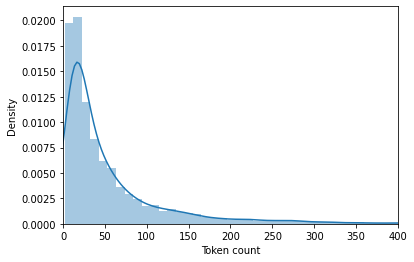

In [18]:
token_lens = []
for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))



sns.distplot(token_lens)
plt.xlim([0, 400]);
plt.xlabel('Token count');

In [19]:
MAX_LEN = 256
# Run function `preprocessing_for_bert` on the train set and the validation set

print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Tokenizing data...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)

train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [21]:
class_names = ['negative', 'positive']

In [22]:
#@misc{ 
 #   swedish-bert,
 #   title={Playing with Words at the National Library of Sweden -- Making a Swedish BERT},
 #   author={Martin Malmsten and Love Börjeson and Chris Haffenden},
 #   year={2020},
 #   eprint={2007.01658},
 #   archivePrefix={arXiv},
 #   primaryClass={cs.CL}
#}

#Custom Classifier

In [23]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('KB/bert-base-swedish-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

#Helper Method
with build in optimizer and scheduler

In [24]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    #bert_classifier = BertClassifier(freeze_bert=False)
    bert_classifier = SentimentClassifier(len(class_names))
   # bert_classifier= BertForSequenceClassification.from_pretrained('KB/bert-base-swedish-cased', return_dict=True)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler


#Training and Evaluation Loop

In [25]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode [ITS JUST A FLAG]
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch) #We take every tokenized sentence and put it to the gpu

            # Zero out any previously calculated gradients
            model.zero_grad() #Refresh the gradients before performing a backward pass

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask) #put b_labels 

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()
            #optimizer.zero_grad()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy


In [26]:
from transformers import BertModel
set_seed(42)    # Set seed for reproducibility

bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
start = time.time()
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)
stop = time.time()
print(f"Training time: {stop - start}s")

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.253311   |     -      |     -     |   28.88  
   1    |   40    |   0.295608   |     -      |     -     |   28.69  
   1    |   60    |   0.156945   |     -      |     -     |   27.73  
   1    |   80    |   0.097488   |     -      |     -     |   27.68  
   1    |   100   |   0.220749   |     -      |     -     |   28.02  
   1    |   120   |   0.097438   |     -      |     -     |   27.83  
   1    |   140   |   0.159289   |     -      |     -     |   27.84  
   1    |   160   |   0.156402   |     -      |     -     |   27.87  
   1    |   180   |   0.116277   |     -      |     -     |   27.95  
   1    |   200   |   0.105966   |     -      |     -     |   27.79  
   1    |   220   |   0.118444   |     -      |     -     |   27.79  
   1    |   240   |   0.152051   |     -      |     -     |   27.83  


In [27]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs


In [28]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#Evaluation

1.   Prepare holdoustset with dataloaders
2.   Predict



In [29]:
#holdout_df

holdout_sentences = holdout_df.text
holdout_label = holdout_df.rating


test_inputs,test_masks = preprocessing_for_bert(holdout_sentences) 

#coverting to torch
test_labels = torch.tensor(holdout_df.rating.array)
#print(holdout_df.rating.array)
print(test_inputs.shape)

#create test Dataloader
test_data = TensorDataset(test_inputs,test_masks,test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data,sampler=test_sampler,batch_size=batch_size)





/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


torch.Size([1000, 256])


In [30]:
from sklearn.metrics import f1_score

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [31]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1)
    labels_flat = labels
    #print( )
    return f1_score(labels_flat, preds_flat, average='weighted')

AUC: 0.4997
Accuracy: 57.00%


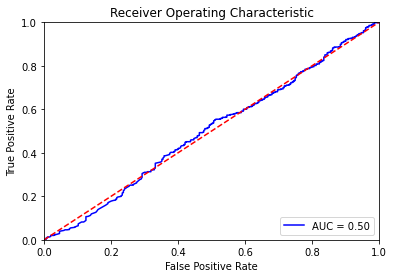

F1 score:  0.5711702412679611
Precision Score:  0.6927536231884058
Recall Score:  0.6867816091954023


In [32]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, holdout_label)

print("F1 score: ", f1_score_func(probs,holdout_label))
probs = np.argmax(probs, axis=1)
print("Precision Score: ", precision_score( holdout_label, probs ))
print("Recall Score: ", recall_score( holdout_label, probs ))

In [33]:
#MACRO
print("Precision Score: ", precision_score( holdout_label, probs, average='macro' ))

Precision Score:  0.49476390836839645
